In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"C:\Users\Laptop World\Desktop\Student KPIs For Elara\Elara_Student_Features.csv"
df = pd.read_csv(file_path)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

df.head()


,Student_ID,Overall_Accuracy,First_Try_Success_Rate,Average_Time_Per_Question,Hard_Question_Accuracy,Attempts_Per_Question,Hint_Usage_Rate,Hint_Efficiency,Time_Before_First_Hint,Post_Hint_Improvement_Score,Topic_Weakness_Count,Score_Trend,Label
0,S001,0.15,0.29,148.08,0.22,2.17,0.84,0.26,40.06,0.14,6,-0.049,Level 1
1,S002,0.39,0.25,231.15,0.06,3.83,0.67,0.00,11.15,0.10,9,-0.030,Level 1
2,S003,0.02,0.29,155.94,0.07,3.54,0.64,0.18,12.32,0.12,10,-0.041,Level 1
3,S004,0.03,0.28,122.87,0.29,2.69,0.92,0.07,44.16,0.12,5,-0.008,Level 1
4,S005,0.07,0.12,213.61,0.05,3.64,0.90,0.06,58.48,0.16,10,-0.003,Level 1


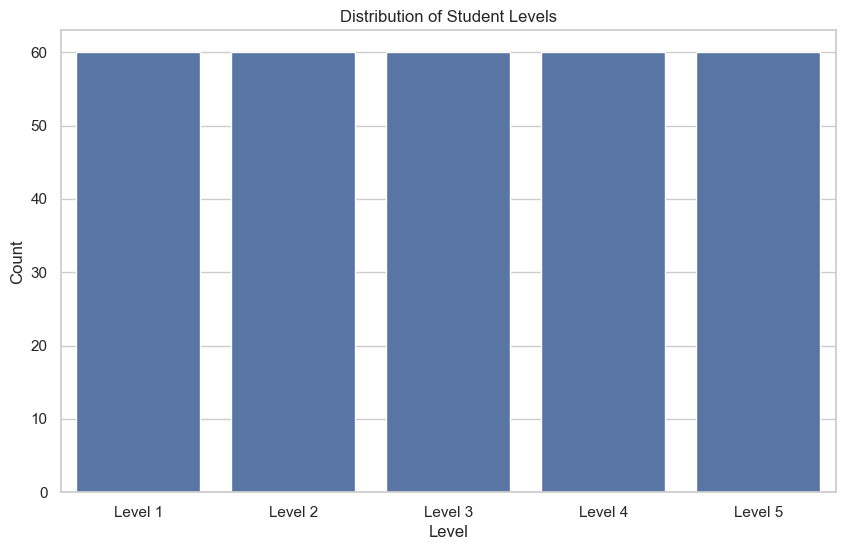

In [2]:
plt.figure()
sns.countplot(x='Label', data=df, order=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])
plt.title("Distribution of Student Levels")
plt.xlabel("Level")
plt.ylabel("Count")
plt.show()


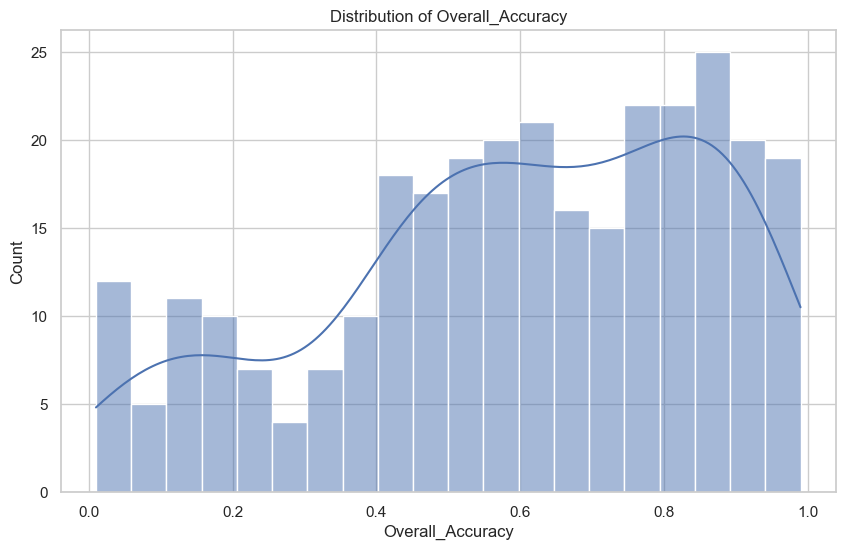

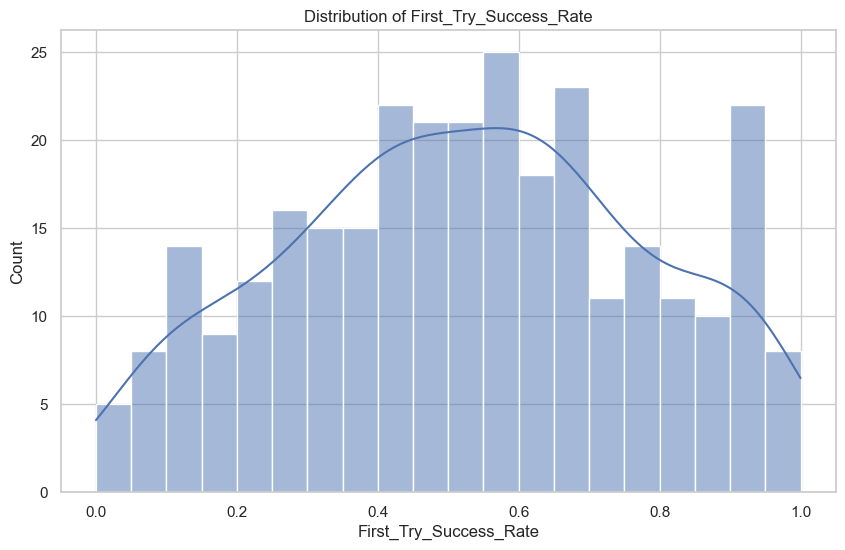

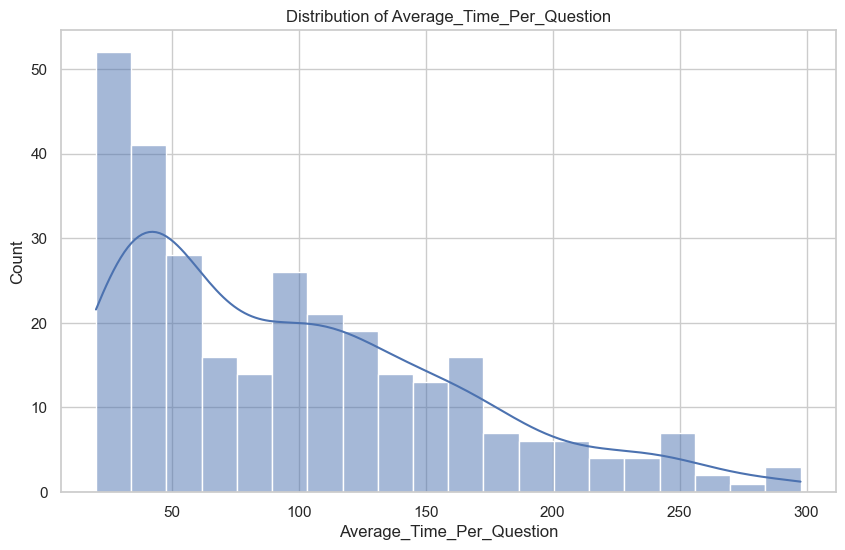

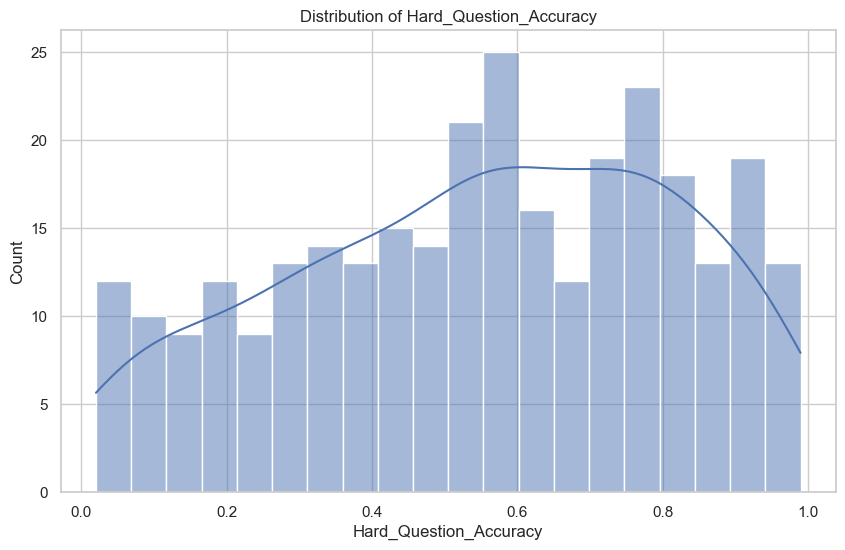

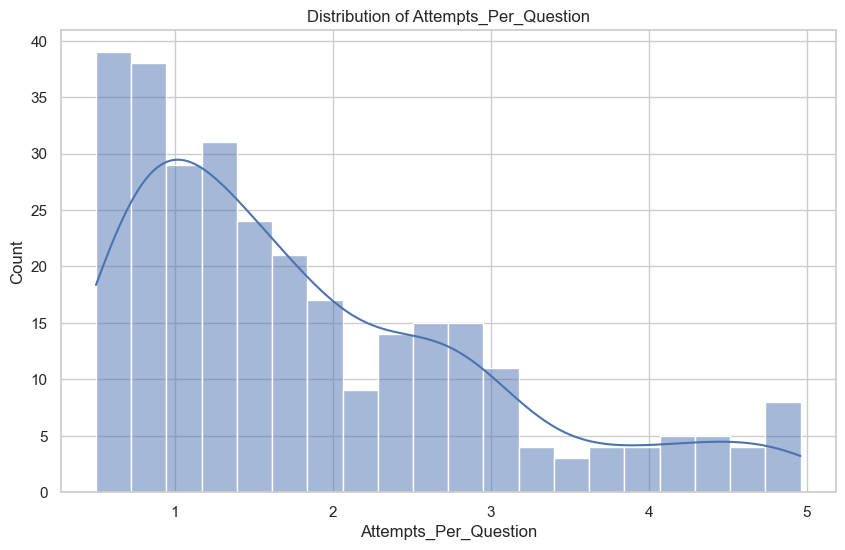

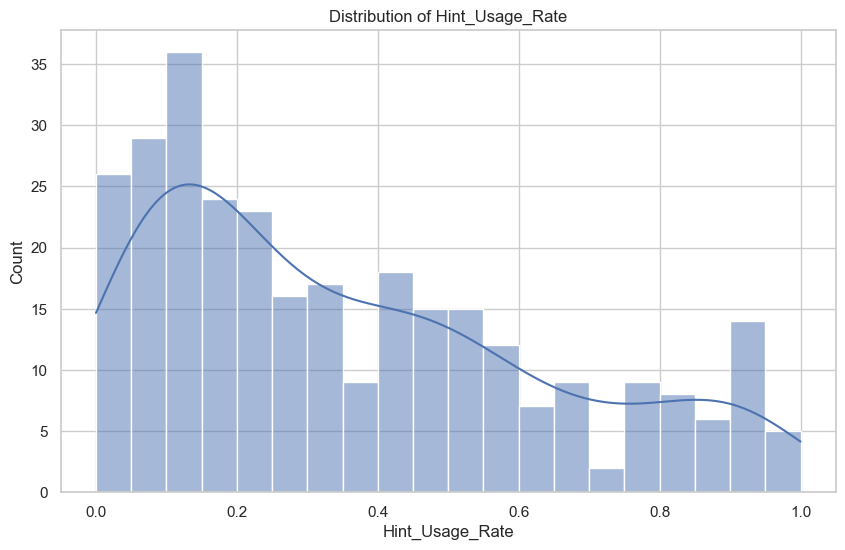

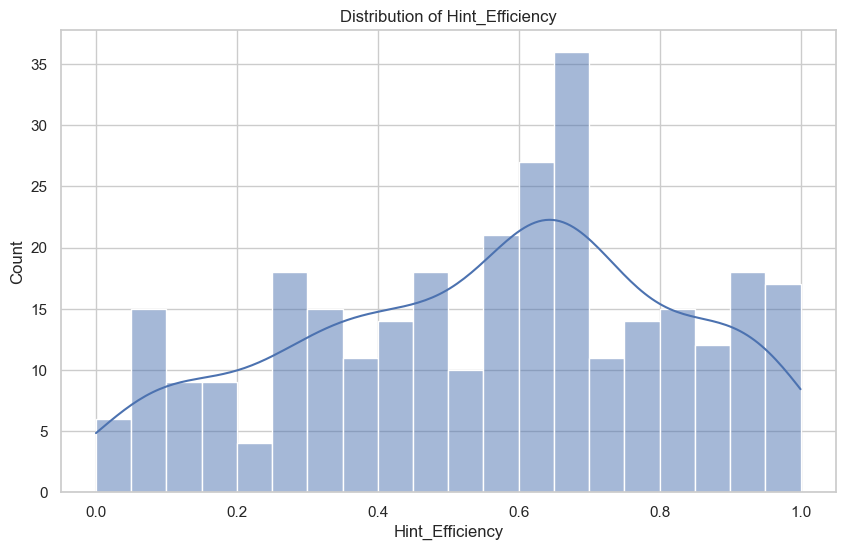

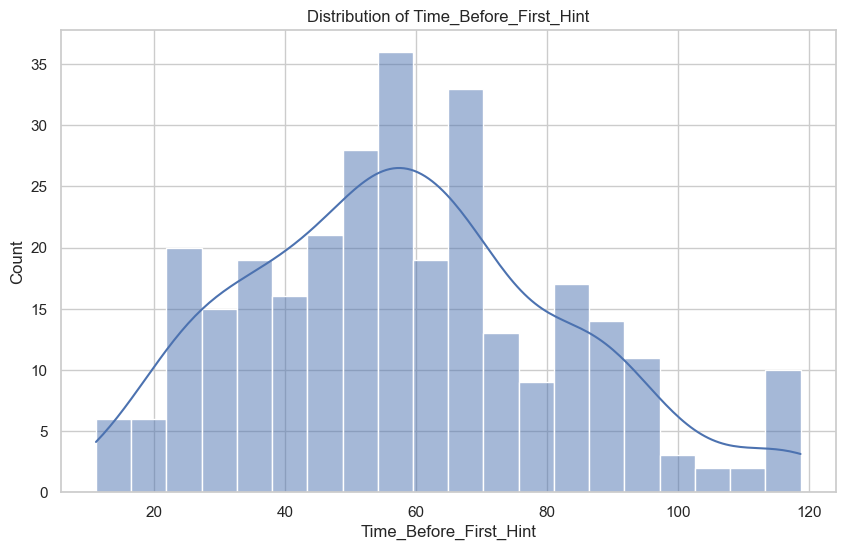

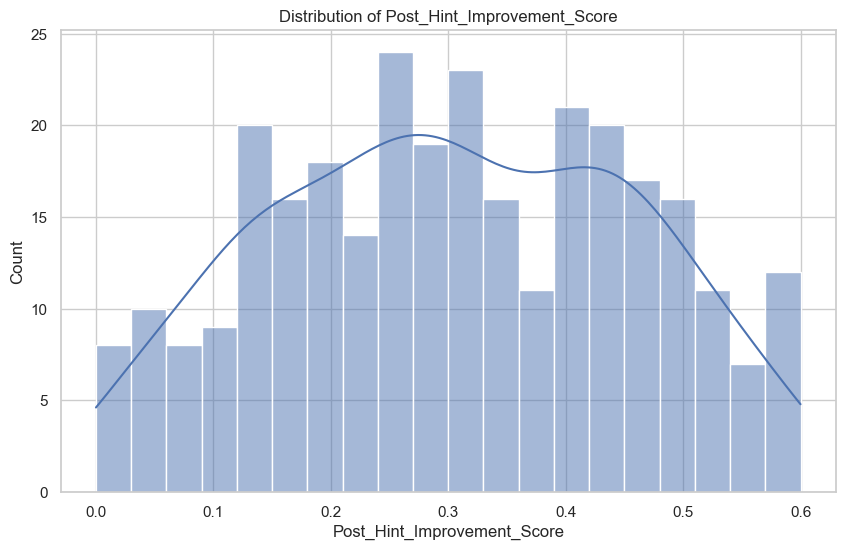

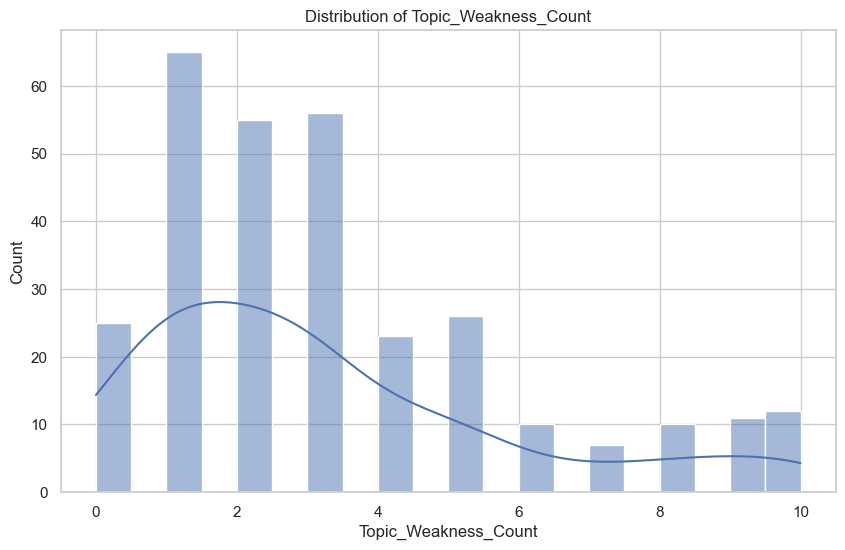

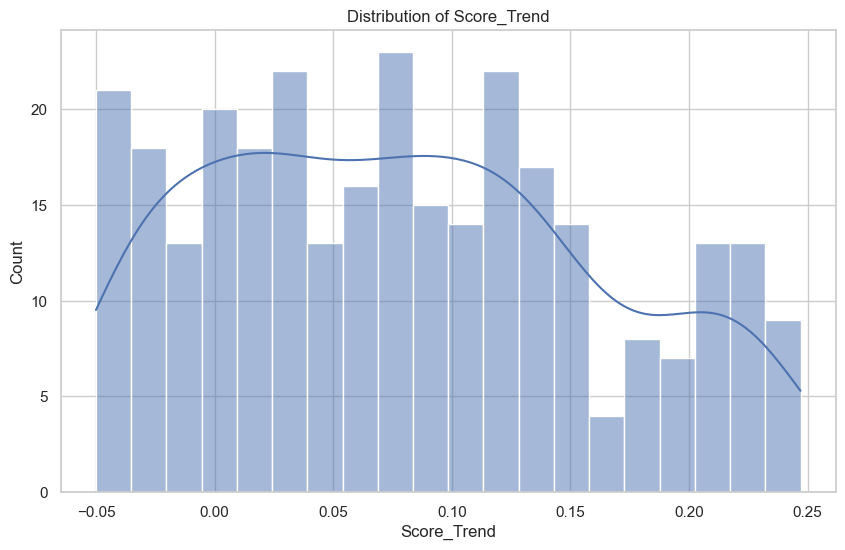

In [3]:
feature_cols = [
    'Overall_Accuracy', 'First_Try_Success_Rate', 'Average_Time_Per_Question',
    'Hard_Question_Accuracy', 'Attempts_Per_Question', 'Hint_Usage_Rate',
    'Hint_Efficiency', 'Time_Before_First_Hint', 'Post_Hint_Improvement_Score',
    'Topic_Weakness_Count', 'Score_Trend'
]

for col in feature_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


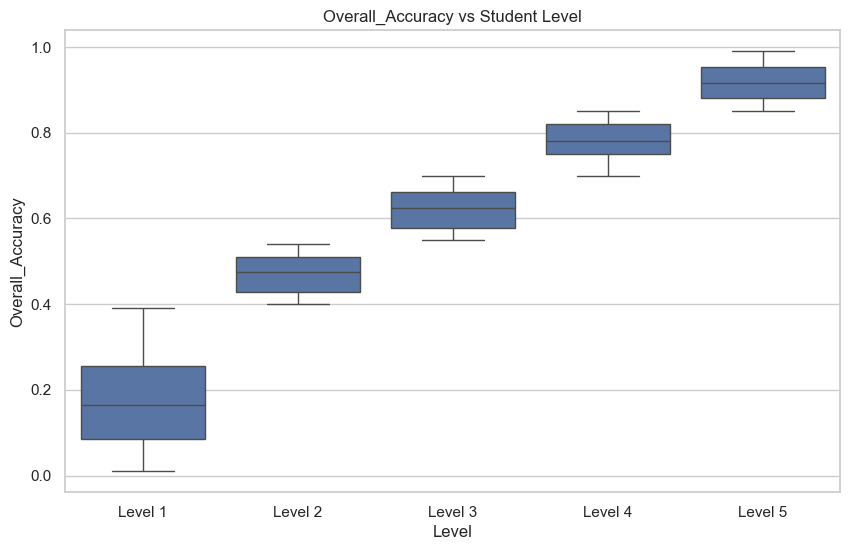

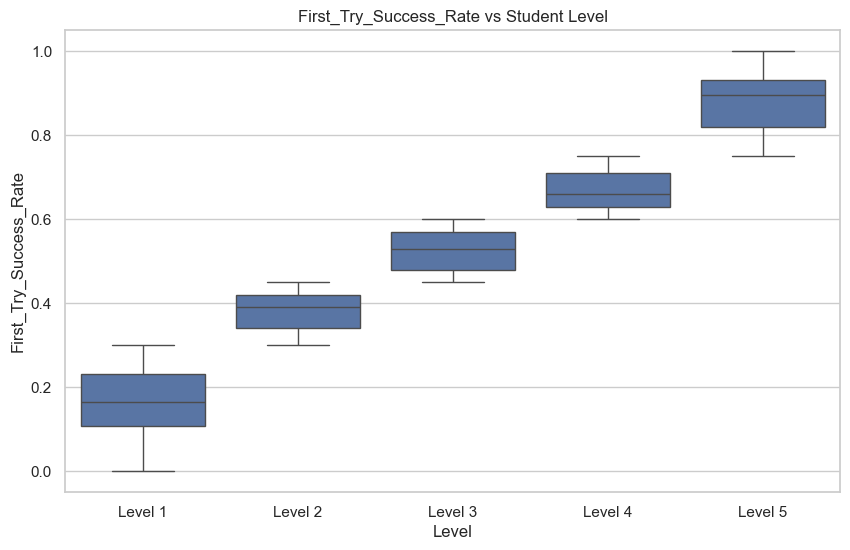

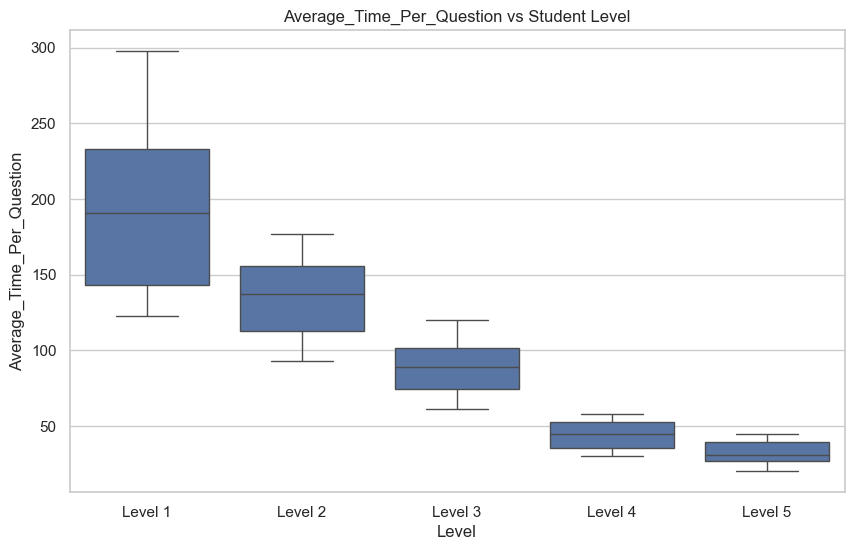

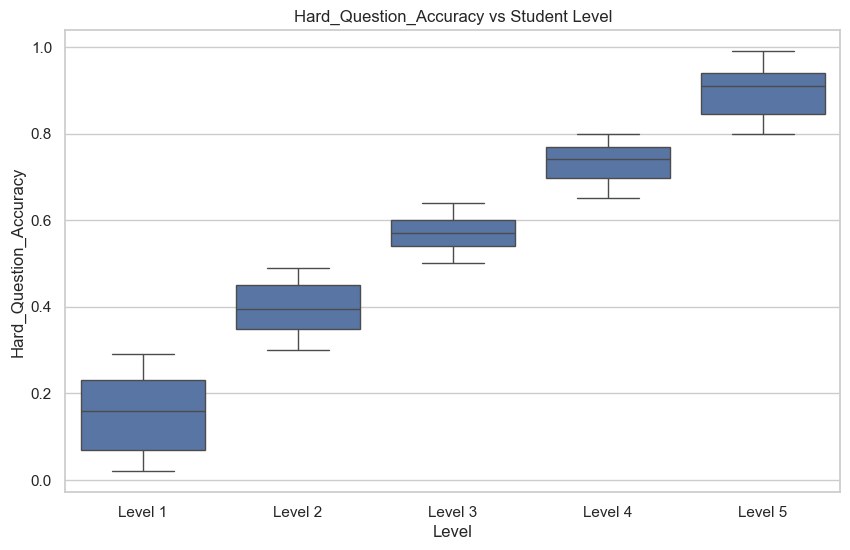

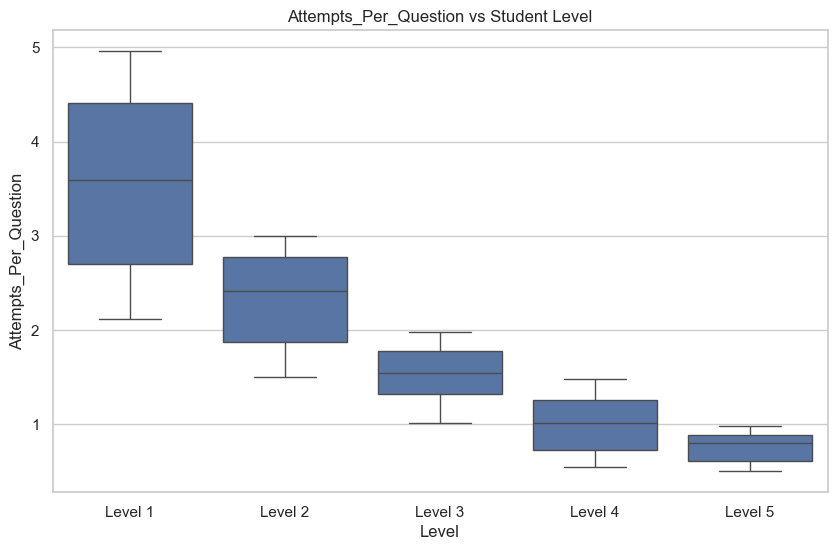

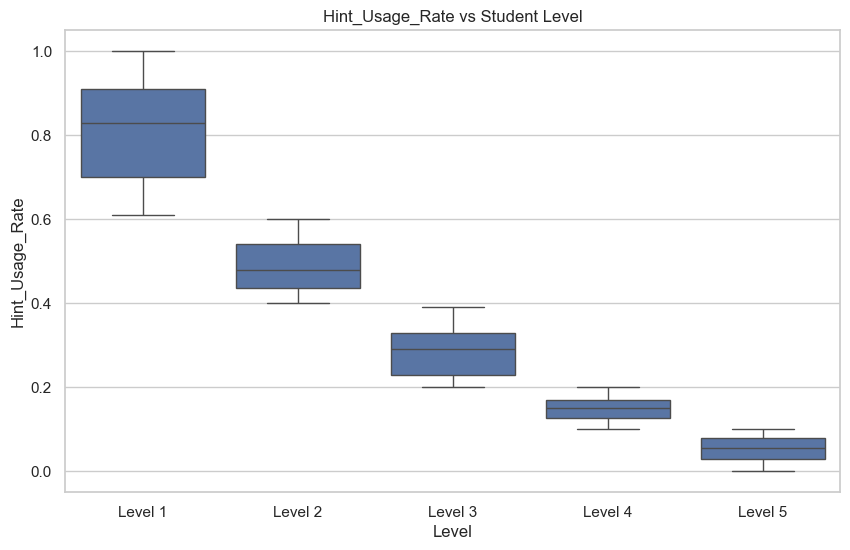

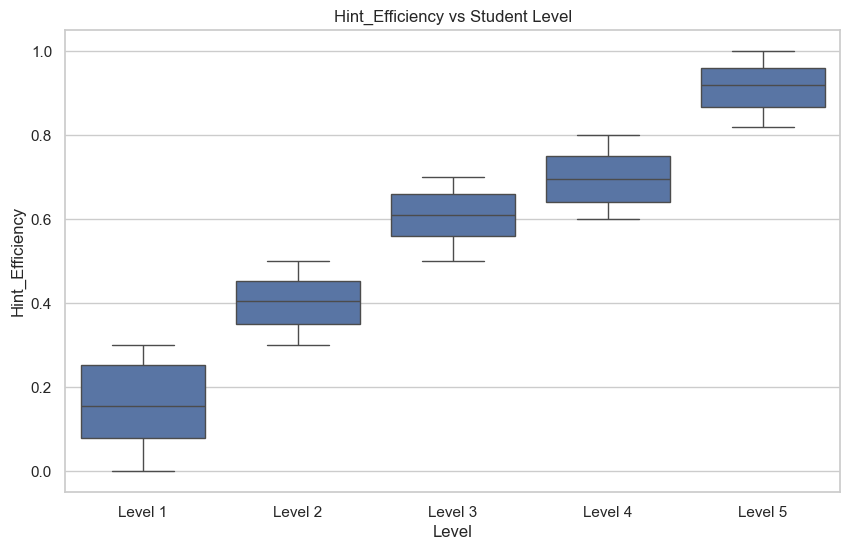

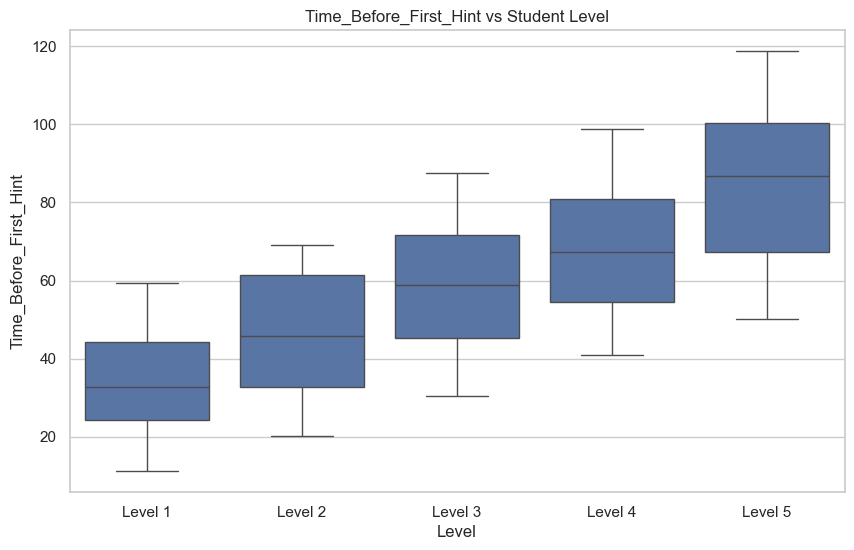

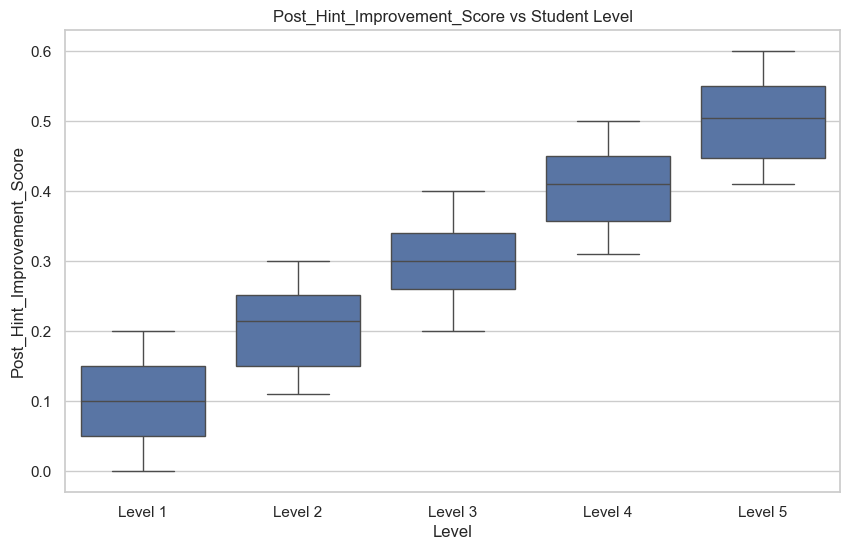

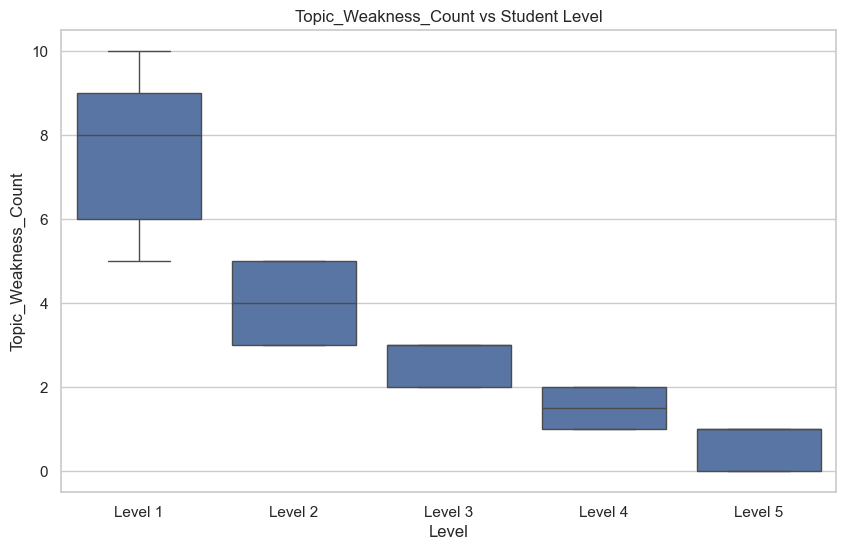

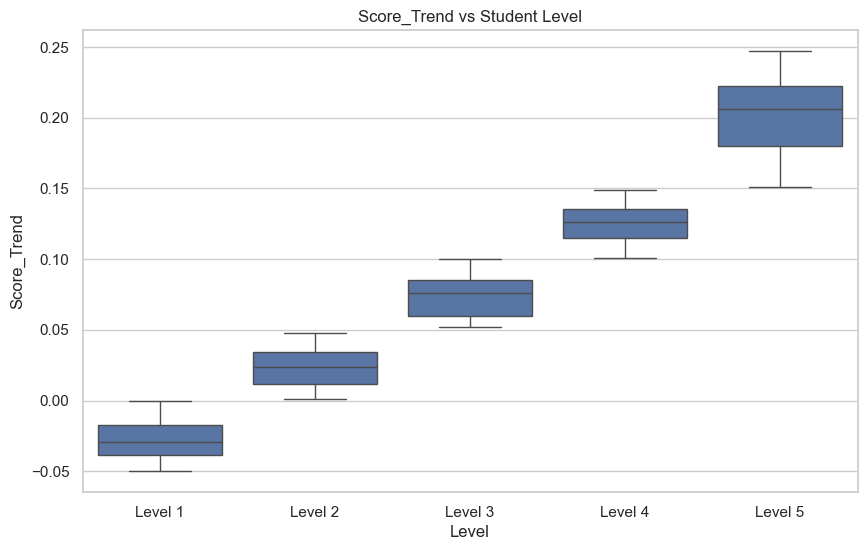

In [4]:
for col in feature_cols:
    plt.figure()
    sns.boxplot(x='Label', y=col, data=df, order=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])
    plt.title(f"{col} vs Student Level")
    plt.xlabel("Level")
    plt.ylabel(col)
    plt.show()


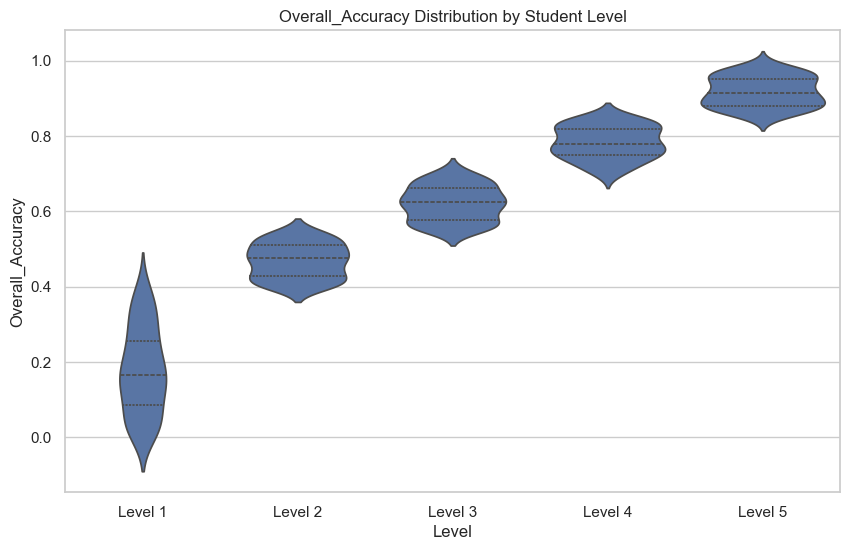

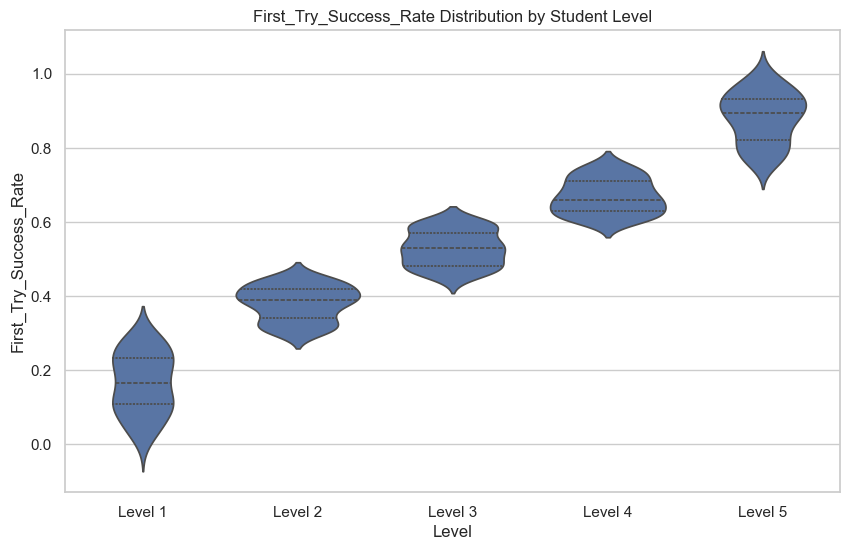

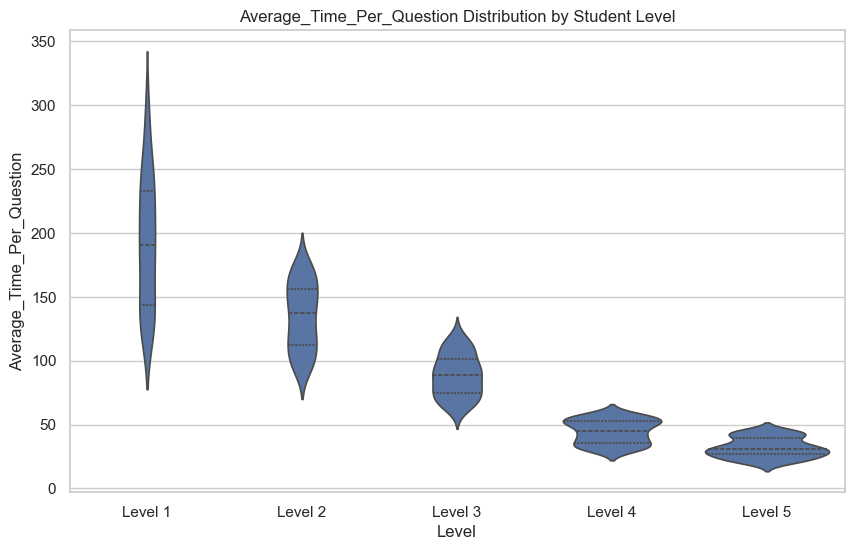

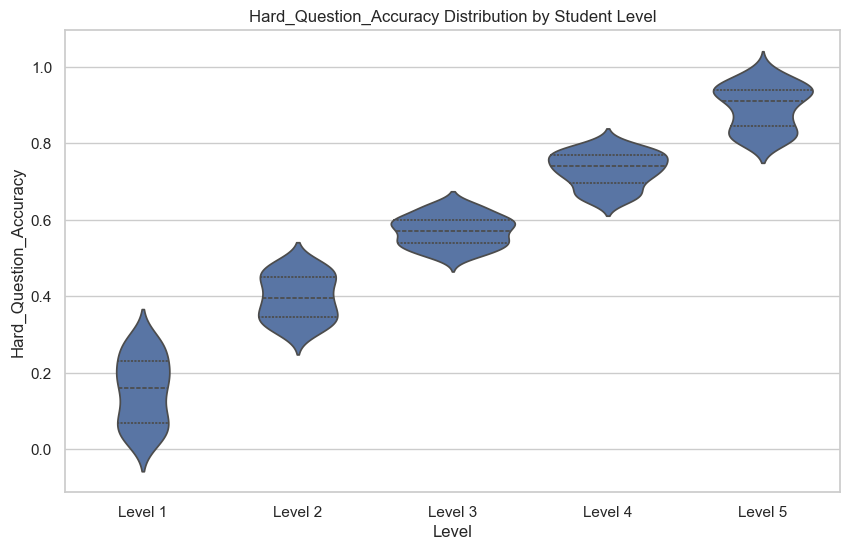

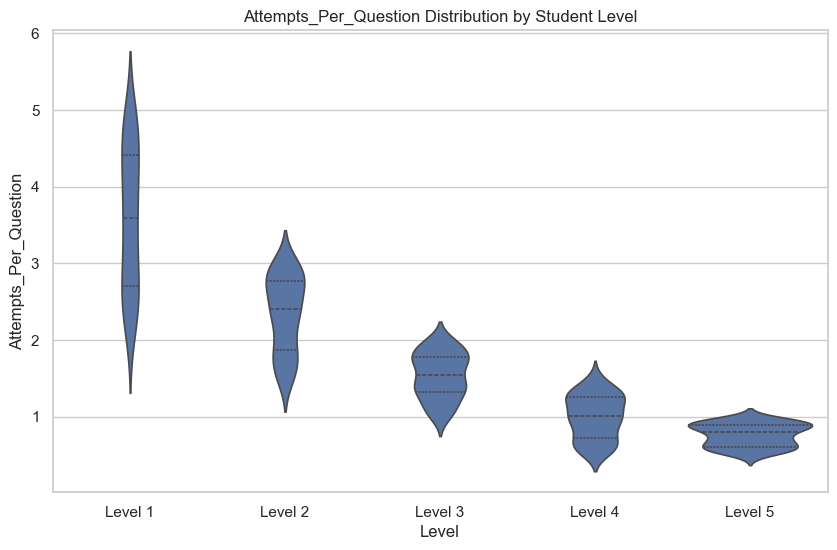

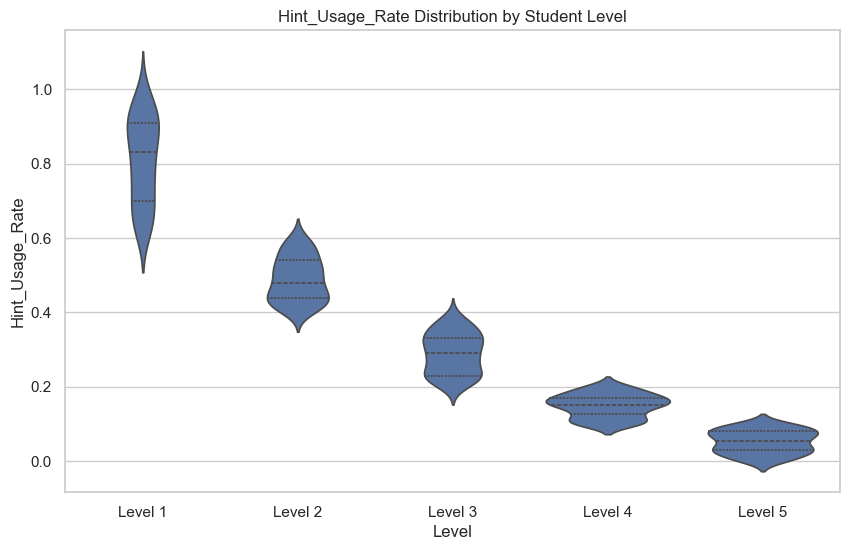

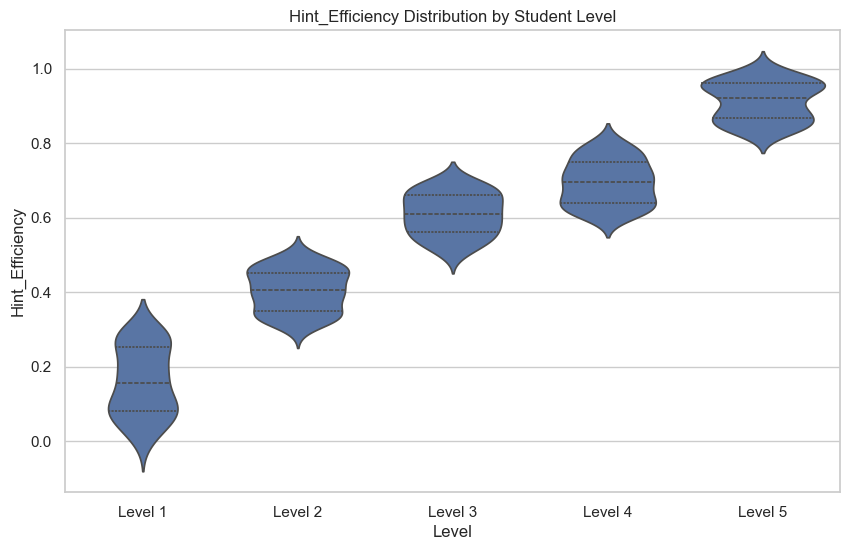

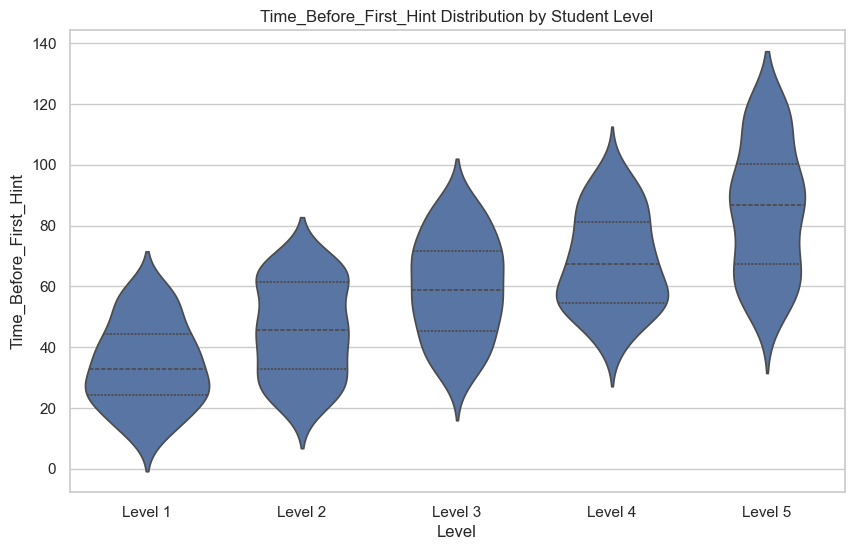

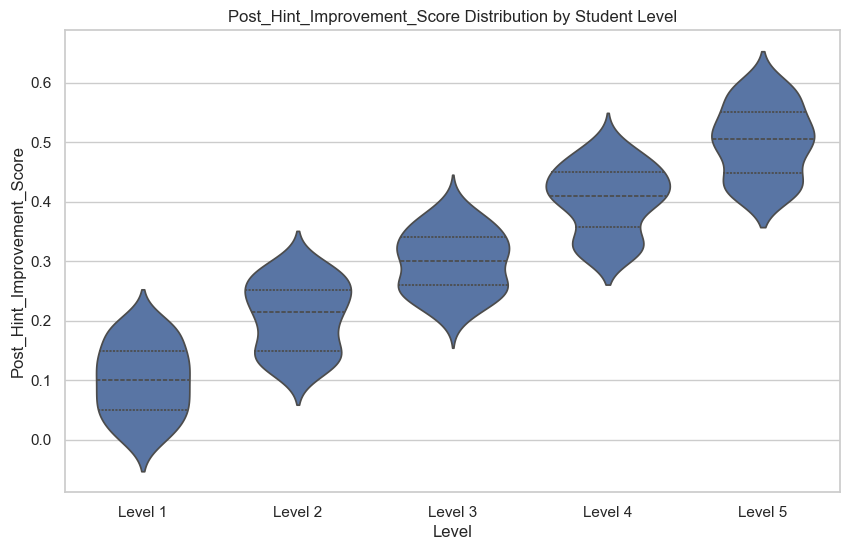

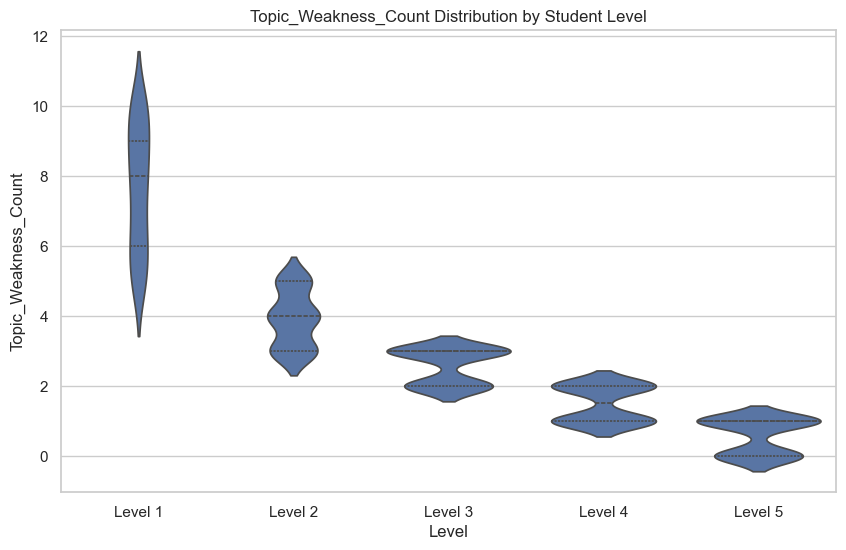

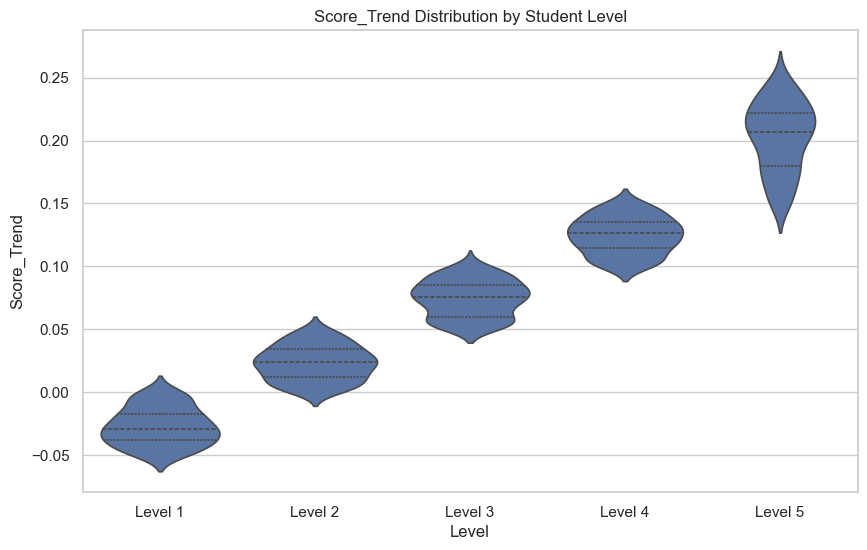

In [5]:
for col in feature_cols:
    plt.figure()
    sns.violinplot(x='Label', y=col, data=df, order=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'], inner="quartile")
    plt.title(f"{col} Distribution by Student Level")
    plt.xlabel("Level")
    plt.ylabel(col)
    plt.show()


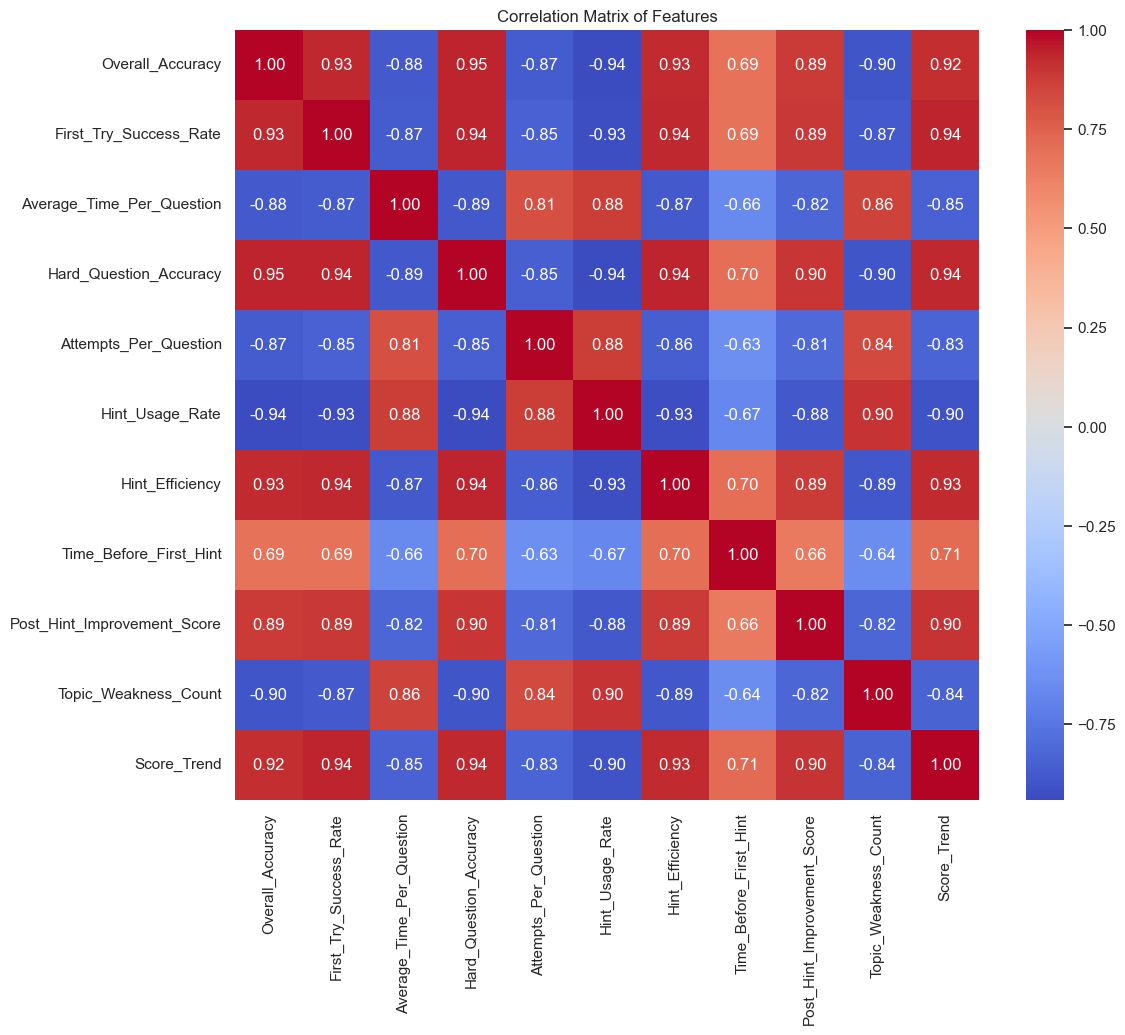

In [12]:
plt.figure(figsize=(12,10))
corr = df[feature_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()


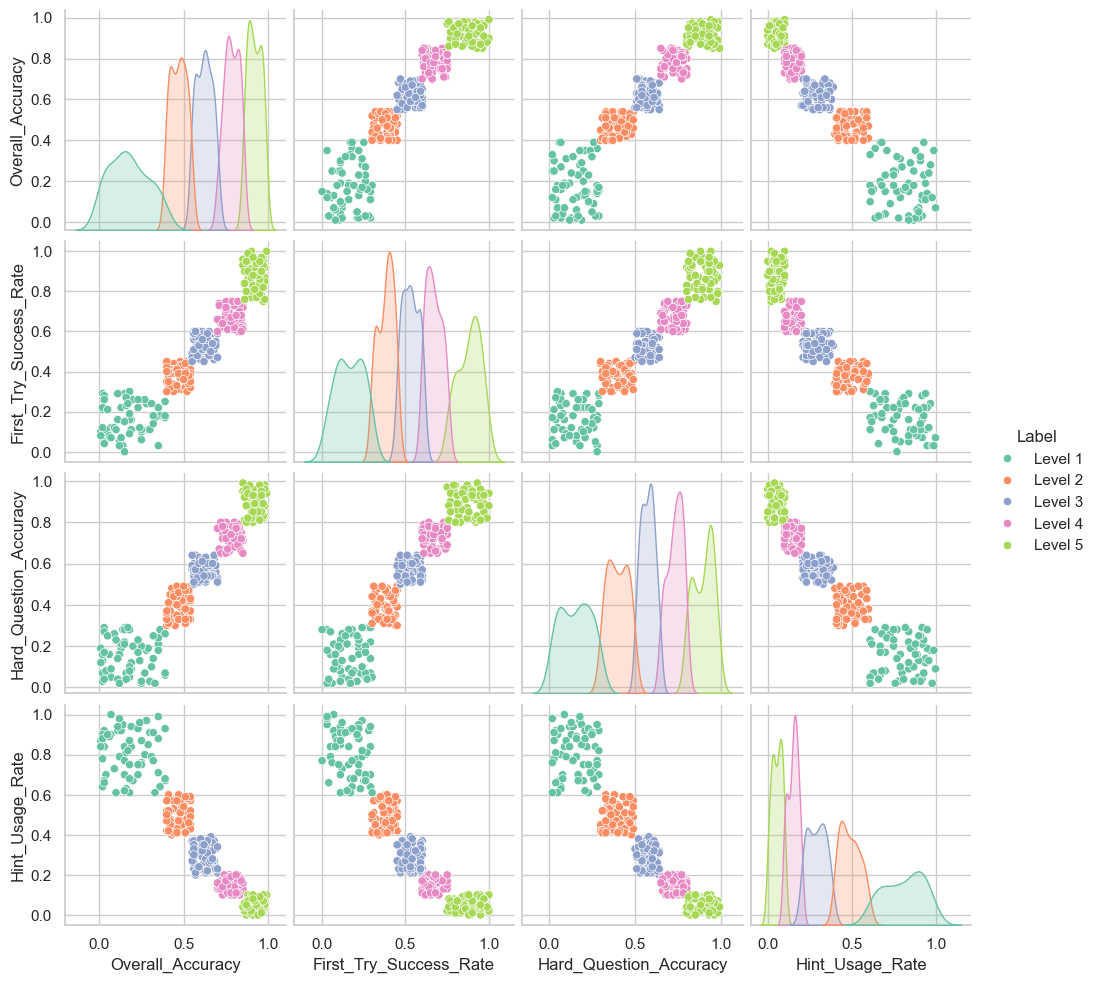

In [13]:
# يمكن تحديد Features المهمة فقط لتقليل التشويش
important_features = ['Overall_Accuracy', 'First_Try_Success_Rate', 'Hard_Question_Accuracy', 'Hint_Usage_Rate']

sns.pairplot(df, vars=important_features, hue='Label', kind='scatter', palette='Set2', diag_kind='kde', hue_order=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])
plt.show()


In [16]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

np.random.seed(42)

# --------------------------------------------------
# Path to your original CSV (غير المسار لو مختلف)
input_path = r"C:\Users\Laptop World\Desktop\Student KPIs For Elara\Elara_Student_Features.csv"
# --------------------------------------------------

# اقرأ البيانات الأصلية
df = pd.read_csv(input_path)

# helper: sample from truncated normal
def truncated_normal(mean, sd, low, high):
    val = np.random.normal(mean, sd)
    attempts = 0
    while (val < low or val > high) and attempts < 10:
        val = np.random.normal(mean, sd)
        attempts += 1
    return np.clip(val, low, high)

def generate_augmented_record_v2(base_record, level):
    rec = base_record.copy()
    scales = {
        'Overall_Accuracy': 0.07,
        'First_Try_Success_Rate': 0.12,
        'Average_Time_Per_Question': 15.0,
        'Hard_Question_Accuracy': 0.07,
        'Attempts_Per_Question': 0.7,
        'Hint_Usage_Rate': 0.12,
        'Hint_Efficiency': 0.12,
        'Time_Before_First_Hint': 15.0,
        'Post_Hint_Improvement_Score': 0.12,
        'Topic_Weakness_Count': 3,
        'Score_Trend': 0.08,
    }

    # 1) نسبةية (0..1) بقيم منقطة
    for col in ['Overall_Accuracy','First_Try_Success_Rate','Hard_Question_Accuracy',
                'Hint_Usage_Rate','Hint_Efficiency','Post_Hint_Improvement_Score']:
        mean = float(rec[col])
        sd = scales[col]
        new = truncated_normal(mean, sd, 0.0, 1.0)
        rec[col] = round(new, 3)

    # 2) time-like features
    for col in ['Average_Time_Per_Question','Time_Before_First_Hint']:
        mean = float(rec[col])
        sd = scales[col]
        new = mean + np.random.normal(0, sd)
        rec[col] = round(max(new, 1.0), 2)

    # 3) attempts and topic weakness
    apq = float(rec['Attempts_Per_Question']) + np.random.normal(0, scales['Attempts_Per_Question'])
    rec['Attempts_Per_Question'] = round(max(apq, 0.1), 2)

    tw = int(rec['Topic_Weakness_Count']) + np.random.randint(-scales['Topic_Weakness_Count'], scales['Topic_Weakness_Count']+1)
    rec['Topic_Weakness_Count'] = int(max(tw, 0))

    # 4) Score_Trend with shocks and allow negatives
    base_trend = float(rec.get('Score_Trend', 0.0))
    p = np.random.rand()
    if p < 0.05:
        new_trend = -abs(np.random.uniform(0.1, 0.5))
    elif p < 0.10:
        new_trend = abs(np.random.uniform(0.1, 0.5))
    else:
        new_trend = base_trend + np.random.normal(0, scales['Score_Trend'])
    rec['Score_Trend'] = round(float(np.clip(new_trend, -0.6, 0.6)), 3)

    # 5) contradictory examples (~12%)
    if np.random.rand() < 0.12:
        contradiction_type = np.random.choice(['highAcc_highHint','lowAcc_highFirstTry','highAcc_manyAttempts','lowAcc_shortTime'])
        if contradiction_type == 'highAcc_highHint':
            rec['Overall_Accuracy'] = round(min(1.0, max(rec['Overall_Accuracy'], np.random.uniform(0.8, 0.98))),3)
            rec['Hint_Usage_Rate'] = round(min(1.0, max(rec['Hint_Usage_Rate'], np.random.uniform(0.3, 0.8))),3)
            rec['First_Try_Success_Rate'] = round(min(1.0, rec['First_Try_Success_Rate']*np.random.uniform(0.6,0.95)),3)
        elif contradiction_type == 'lowAcc_highFirstTry':
            rec['Overall_Accuracy'] = round(min(1.0, rec['Overall_Accuracy'] * np.random.uniform(0.3,0.6)),3)
            rec['First_Try_Success_Rate'] = round(min(1.0, max(rec['First_Try_Success_Rate'], np.random.uniform(0.6,0.9))),3)
        elif contradiction_type == 'highAcc_manyAttempts':
            rec['Overall_Accuracy'] = round(min(1.0, max(rec['Overall_Accuracy'], np.random.uniform(0.8,0.98))),3)
            rec['Attempts_Per_Question'] = round(max(rec['Attempts_Per_Question'], np.random.uniform(1.5,4.0)),3)
        elif contradiction_type == 'lowAcc_shortTime':
            rec['Overall_Accuracy'] = round(min(1.0, rec['Overall_Accuracy'] * np.random.uniform(0.2,0.6)),3)
            rec['Average_Time_Per_Question'] = round(max(1.0, rec['Average_Time_Per_Question'] * np.random.uniform(0.2,0.6)),2)

    # 6) outliers small probability (~2%)
    if np.random.rand() < 0.02:
        out_col = np.random.choice(['Average_Time_Per_Question','Topic_Weakness_Count','Hint_Usage_Rate'])
        if out_col == 'Average_Time_Per_Question':
            rec[out_col] = round(rec[out_col] * np.random.uniform(2.0,5.0),2)
        elif out_col == 'Topic_Weakness_Count':
            rec[out_col] = int(rec[out_col] + np.random.randint(5, 15))
        elif out_col == 'Hint_Usage_Rate':
            rec[out_col] = round(min(1.0, rec[out_col] + np.random.uniform(0.3,0.7)),3)

    # bounds safety
    for col in ['Overall_Accuracy','First_Try_Success_Rate','Hard_Question_Accuracy',
                'Hint_Usage_Rate','Hint_Efficiency','Post_Hint_Improvement_Score']:
        rec[col] = float(np.clip(rec[col], 0.0, 1.0))

    rec['Attempts_Per_Question'] = float(max(rec['Attempts_Per_Question'], 0.1))
    rec['Topic_Weakness_Count'] = int(max(rec['Topic_Weakness_Count'], 0))

    rec['Label'] = level
    return rec

def augment_dataset(df, target_total=90000):
    existing = df.to_dict(orient='records')
    augmented = []
    while len(augmented) + len(existing) < target_total:
        base = np.random.choice(existing)
        lvl = base['Label']
        new_rec = generate_augmented_record_v2(base, lvl)
        augmented.append(new_rec)
    df_aug = pd.concat([df, pd.DataFrame(augmented)], ignore_index=True)
    return df_aug

# ================= execute augmentation =================
df_augmented = augment_dataset(df, target_total=90000)

# ================= save augmented CSV in same folder as input =================
input_dir = os.path.dirname(input_path)
base_name = "Student_KPIs_Elara_Augmented_v2"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_name = f"{base_name}_{timestamp}.csv"
output_path = os.path.join(input_dir, output_name)

df_augmented.to_csv(output_path, index=False)
print(f"Augmented dataset saved to: {output_path}")


Augmented dataset saved to: C:\Users\Laptop World\Desktop\Student KPIs For Elara\Student_KPIs_Elara_Augmented_v2_20251128_185150.csv
